# Tripartite relational data analysis
Try to find the characteristics of relational datasets that consist of the tripartite network from two published papers.

In [206]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the data
dme_df = pd.read_excel('MAHN/association_DME.xlsx')
dmi_df = pd.read_excel('MAHN/association_DMI.xlsx')
mime_df = pd.read_excel('MAHN/association_MIME.xlsx')

In [3]:
print(f"Unique edges in DME: {len(dme_df[['Disease', 'Metabolite']].drop_duplicates())}")
print(f"Unique edges in DMI: {len(dmi_df[['Disease', 'Microbe']].drop_duplicates())}")
print(f"Unique edges in MIME: {len(mime_df[['Microbe', 'Metabolite']].drop_duplicates())}")

Unique edges in DME: 10604
Unique edges in DMI: 13552
Unique edges in MIME: 74228


In [4]:
common_microbes = set(dmi_df["Microbe"]) | set(mime_df["Microbe"])

print(f"Common microbes in D-MI: {(len(common_microbes)/len(dmi_df['Microbe'].unique()))*100}%")
print(f"Common microbes in MI-ME: {(len(common_microbes)/len(mime_df['Microbe'].unique()))*100}%")

Common microbes in D-MI: 100.0%
Common microbes in MI-ME: 100.0%


In [5]:
common_metabolites = set(dme_df["Metabolite"]) | set(mime_df["Metabolite"])

print(f"Common metabolites in D-ME: {(len(common_metabolites)/len(dme_df['Metabolite'].unique()))*100}%")
print(f"Common metabolites in MI-ME: {(len(common_metabolites)/len(mime_df['Metabolite'].unique()))*100}%")

Common metabolites in D-ME: 100.0%
Common metabolites in MI-ME: 100.0%


In [6]:
common_diseases = set(dme_df["Disease"]) | set(dmi_df["Disease"])

print(f"Common diseases in D-ME: {(len(common_diseases) / len(dme_df['Disease'].unique())) * 100}%")
print(f"Common diseases in D-MI: {(len(common_diseases) / len(dmi_df['Disease'].unique())) * 100}%")

Common diseases in D-ME: 100.0%
Common diseases in D-MI: 100.0%


In [7]:
G = nx.Graph()

microbe_offset = len(dme_df["Disease"].unique())
metabolite_offset = len(dme_df["Disease"].unique()) + len(dmi_df["Microbe"].unique())

# add edges from the DME file (10604)
for _, row in dme_df.iterrows():
    G.add_edge(int(row['Disease']), int(row['Metabolite']) + metabolite_offset, type='DME')

# add edges from the DMI file (13552)
for _, row in dmi_df.iterrows():
    G.add_edge(int(row['Disease']), int(row['Microbe']) + microbe_offset, type='DMI')

# add edges from the MIME file (74228)
for _, row in mime_df.iterrows():
    G.add_edge(int(row['Microbe']) + microbe_offset, int(row['Metabolite']) + metabolite_offset, type='MIME')

In [8]:
# tag node types
for node in G.nodes():
    if node in dme_df['Disease'].values or node in dmi_df['Disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in dmi_df['Microbe'].values or node in mime_df['Microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in dme_df['Metabolite'].values or node in mime_df['Metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [9]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 593
Total edges: 98384


In [10]:
degree_centrality = nx.degree_centrality(G)

In [11]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 56.05% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.2748068535275868


In [12]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [13]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 593,
 'mean': np.float64(331.8178752107926),
 'std': np.float64(69.30963264905772),
 'min': np.int64(285),
 '25%': np.float64(285.0),
 '50% (median)': np.float64(285.0),
 '75%': np.float64(352.0),
 'max': np.int64(549)}

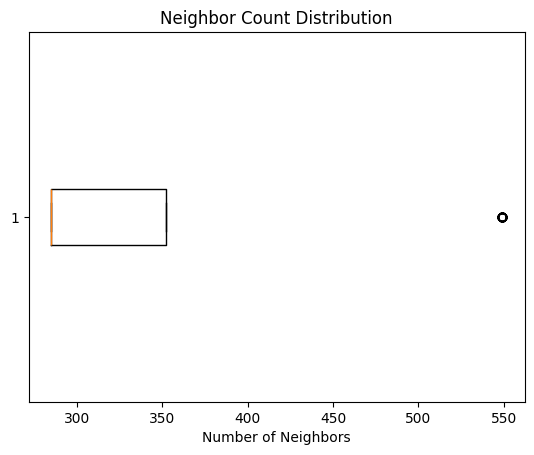

In [14]:
# box plot of neighbor counts
plt.boxplot(neighbor_counts.values(), vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

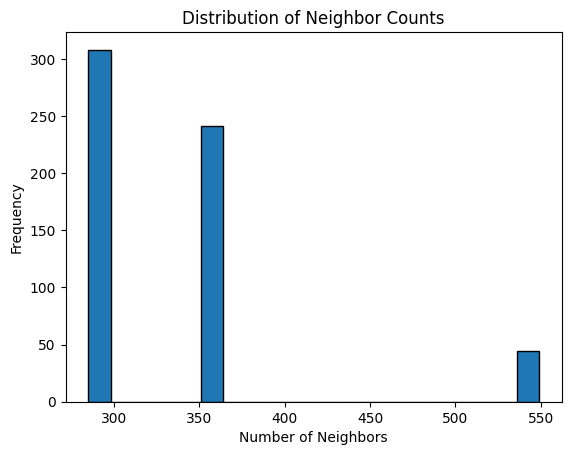

In [15]:
# histogram of neighbor counts
plt.hist(neighbor_counts.values(), bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [16]:
microbe_offset = len(dme_df["Disease"].unique())
metabolite_offset = len(dme_df["Disease"].unique()) + len(dmi_df["Microbe"].unique())

nodes = []
for disease in set(sorted(dme_df["Disease"])) | set(sorted(dmi_df["Disease"])):
    nodes.append([int(disease), "disease", "red"])
for microbe in set(sorted(dmi_df["Microbe"])) | set(sorted(mime_df["Microbe"])):
    nodes.append([int(microbe) + microbe_offset, "microbe", "blue"])
for metabolite in set(sorted(dme_df["Metabolite"])) | set(sorted(mime_df["Metabolite"])):
    nodes.append([int(metabolite) + metabolite_offset, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("MAHN_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[int(disease), int(metabolite) + metabolite_offset, value]
     for disease, metabolite, value in dme_df[["Disease", "Metabolite", "Value"]].values]
)
edges.extend(
    [[int(disease), int(microbe) + microbe_offset, value]
     for disease, microbe, value in dmi_df[["Disease", "Microbe", "Value"]].values]
)
edges.extend(
    [[int(microbe) +microbe_offset, int(metabolite) + metabolite_offset, value]
     for microbe, metabolite, value in mime_df[["Microbe", "Metabolite", "Value"]].values]
)
edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("MAHN_edges_with_labels.csv", index=False)

### Summary of MAHN datasets
- The MAHN datasets consist of three relational datasets: Disease-Metabolite (DME), Disease-Microbe (DMI), and Microbe-Metabolite (MIME).
- The DME dataset has 10604 unique edges, the DMI dataset has 13552 unique edges, and the MIME dataset has 74228 unique edges. Total edges are 98384.
- Total node count is 593 with 44 unique diseases, 308 unique microbes, and 241 unique metabolites.
- Common microbes are 100% in both files, common diseases are 100% in both files, and common metabolites are 100% in both files.
- The relational datasets from MAHN has 1 connected large component.
- Average neighbor count is ~331, median count is 285.

***

In [195]:
u_a = pd.read_csv("MAGNN_user_artist/user_artist.dat", sep="\t", encoding="utf-8", header=None, names=["user", "artist", "weight"])
u_u = pd.read_csv("MAGNN_user_artist/user_user(original).dat", sep="\t", encoding="utf-8", header=None, names=["user1", "user2"])
a_t = pd.read_csv("MAGNN_user_artist/artist_tag.dat", sep="\t", encoding="utf-8", header=None, names=["artist", "tag"])

In [18]:
print(f"Unique edges in u_a: {len(u_a[['user', 'artist']].drop_duplicates())}")
print(f"Unique edges in u_u: {len(u_u[['user1', 'user2']].drop_duplicates())}")
print(f"Unique edges in a_t: {len(a_t[['artist', 'tag']].drop_duplicates())}")

Unique edges in u_a: 92834
Unique edges in u_u: 25434
Unique edges in a_t: 108437


In [19]:
user = len(u_a["user"].unique())
artist = len(u_a["artist"].unique())
print(f"Number of users: {user}")
print(f"Number of artists: {artist}")

Number of users: 1892
Number of artists: 17632


In [20]:
u1 = len(u_u["user1"].unique())
u2 = len(u_u["user2"].unique())
print(f"Number of user1: {u1}")
print(f"Number of user2: {u2}")

Number of user1: 1892
Number of user2: 1892


In [21]:
artist = len(a_t["artist"].unique())
tag = len(a_t["tag"].unique())
print(f"Number of artists: {artist}")
print(f"Number of tags: {tag}")

Number of artists: 12133
Number of tags: 9718


In [22]:
common_users = set(u_a["user"]) & set(u_u["user1"]) & set(u_u["user2"])

print(f"Common users in U-A: {(len(common_users)/len(u_a['user'].unique()))*100}%")
print(f"Common users in U-U user1: {(len(common_users)/len(u_u['user1'].unique())*100)}%")
print(f"Common users in U-U user2: {(len(common_users)/len(u_u['user2'].unique())*100)}%")

Common users in U-A: 100.0%
Common users in U-U user1: 100.0%
Common users in U-U user2: 100.0%


In [23]:
common_artists = set(u_a["artist"]) & set(a_t["artist"])

print(f"Common artists in U-A: {(len(common_artists)/len(u_a['artist'].unique()))*100:.2f}%")
print(f"Common artists in A-T: {(len(common_artists)/len(a_t['artist'].unique())*100)}%")

Common artists in U-A: 68.81%
Common artists in A-T: 100.0%


In [24]:
G = nx.Graph()
artist_offset = len(u_a["user"].unique())
tag_offset = len(u_a["user"].unique()) + len(u_a["artist"].unique())

for _, row in u_a.iterrows():
    G.add_edge(int(row['user']), int(row['artist']) + artist_offset, type='user_artist')

for _, row in u_u.iterrows():
    G.add_edge(int(row['user1']), int(row['user2']), type='user_user')

for _, row in a_t.iterrows():
    G.add_edge(int(row['artist']) + artist_offset, int(row['tag']) + tag_offset, type='artist_tag')

In [25]:
for node in G.nodes():
    if node in u_a['user'].values or node in u_u['user1'].values or node in u_u["user2"].values:
        G.nodes[node]['type'] = 'user'
    elif node in u_a['artist'].values or node in a_t['artist'].values:
        G.nodes[node]['type'] = 'artist'
    elif node in a_t['tag'].values:
        G.nodes[node]['type'] = 'tag'

In [26]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 29242
Total edges: 213988


In [27]:
degree_centrality = nx.degree_centrality(G)

In [28]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.05% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.11872850770837678


In [29]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [30]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 29242,
 'mean': np.float64(14.635661035496888),
 'std': np.float64(45.737698015849865),
 'min': np.int64(1),
 '25%': np.float64(1.0),
 '50% (median)': np.float64(3.0),
 '75%': np.float64(11.0),
 'max': np.int64(2248)}

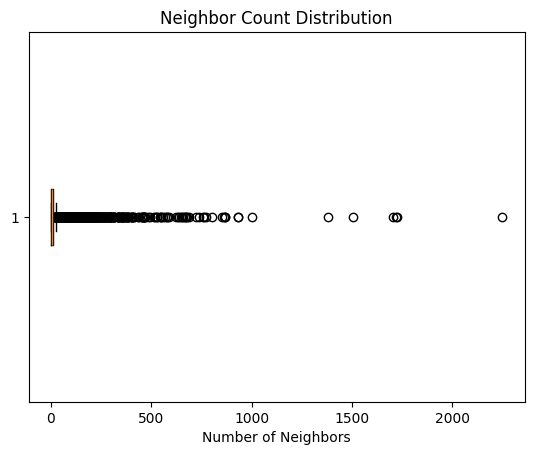

In [31]:
# box plot of neighbor counts
plt.boxplot(neighbor_counts.values(), vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

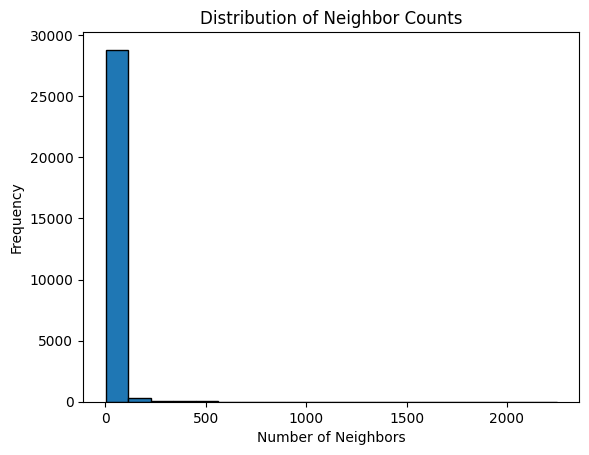

In [32]:
# histogram of neighbor counts
plt.hist(neighbor_counts.values(), bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [196]:
artist_offset = len(u_a["user"].unique())
tag_offset = len(u_a["user"].unique()) + len(u_a["artist"].unique())

nodes = []
for user in set(sorted(u_a["user"])) | set(sorted(u_u["user1"])) | set(sorted(u_u["user2"])):
    nodes.append([int(user), "user", "red"])
for artist in set(sorted(u_a["artist"])) | set(sorted(a_t["artist"])):
    nodes.append([int(artist) + artist_offset, "artist", "blue"])
for tag in set(sorted(a_t["tag"])):
    nodes.append([int(tag) + tag_offset, "tag", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("LastFM_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[int(user), int(artist) + artist_offset, value]
     for user, artist, value in u_a[["user", "artist", "weight"]].values]
)
edges.extend(
    [[int(user1), int(user2), 1]
     for user1, user2 in u_u[["user1", "user2"]].values]
)
edges.extend(
    [[int(artist) + artist_offset, int(tag) + tag_offset, 1]
     for artist, tag in a_t[["artist", "tag"]].values]
)
edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("LastFM_edges_with_labels.csv", index=False)

### Summary of MAGNN user-artist-tag datasets
- The MAGNN user-artist-tag datasets consist of three relational datasets: User-Artist (U-A), User-User (U-U), and Artist-Tag (A-T).
- The U-A dataset has 92,834 unique edges, U-U dataset has 25,434 unique edges, and the A-T dataset has 108,437 unique edges. Total edges of networkx are 213,988. However, the total edges of the dataset are 226,705, there are duplicated edges in the three datasets.
- Unique node count is 29,242 with 1892 unique users, 17632 unique artists, and 9718 unique tags.
- Common users are 100% in both files, 100% common artists in one file and 68.81% common artists in another file.
- The relational datasets from MAGNN has 1 connected large component.
- Average neighbor count is ~15, median neighbor count is 3.

***

In [197]:
disbiome_md = pd.read_csv("MKG/disbiome_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
gmmad2_mmet = pd.read_csv("MKG/gmmad2_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])
gmmad2_md = pd.read_csv("MKG/gmmad2_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
hmdb_metd = pd.read_csv("MKG/hmdb_met_disease.dat", sep="\t", encoding="utf-8", header=None, names=["metabolite", "disease"])
hmdb_mmet = pd.read_csv("MKG/hmdb_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])

In [123]:
common_microbes = set(disbiome_md["microbe"]) & set(gmmad2_mmet["microbe"]) & set(gmmad2_md["microbe"])
common_diseases = set(disbiome_md["disease"]) & set(gmmad2_md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(gmmad2_mmet["metabolite"]) & set(hmdb_metd["metabolite"]) & set(hmdb_mmet["metabolite"])

print(f"number of common microbes: {len(common_microbes)}")
print(f"number of common diseases: {len(common_diseases)}")
print(f"number of common metabolites: {len(common_metabolites)}")

number of common microbes: 60
number of common diseases: 9
number of common metabolites: 80


In [198]:
md = pd.concat([disbiome_md, gmmad2_md])
m_ct = len(md['microbe'].unique())
print(f"Number of unique microbes: {m_ct}")
print(f"Number of unique diseases: {len(md['disease'].unique())}")

Number of unique microbes: 7167
Number of unique diseases: 345


In [199]:
mmet = pd.concat([gmmad2_mmet, hmdb_mmet])
print(f"Number of unique microbes: {len(mmet['microbe'].unique())}")
print(f"Number of unique metabolites: {len(mmet['metabolite'].unique())}")

Number of unique microbes: 1308
Number of unique metabolites: 1716


In [126]:
print(f"Number of unique metabolites: {len(hmdb_metd['metabolite'].unique())}")
print(f"Number of unique diseases: {len(hmdb_metd['disease'].unique())}")

Number of unique metabolites: 22590
Number of unique diseases: 593


In [127]:
print(f"Unique edges in md: {len(md[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in mmet: {len(mmet[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in hmdb_metd: {len(hmdb_metd[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in md: 505325
Unique edges in mmet: 599176
Unique edges in hmdb_metd: 27546


In [128]:
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])

print(f"Number of common microbes: {len(common_microbes)}")
print(f"Number of common diseases: {len(common_diseases)}")
print(f"Number of common metabolites: {len(common_metabolites)}")

print(f"Common microbes in M-D: {(len(common_microbes)/len(md['microbe'].unique()))*100:.2f}%")
print(f"Common microbes in M-MET: {(len(common_microbes)/len(mmet['microbe'].unique()))*100:.2f}%")
print(f"Common diseases in M-D: {(len(common_diseases) / len(md['disease'].unique())) * 100:.2f}%")
print(f"Common diseases in HMDB_MET-D: {(len(common_diseases) / len(hmdb_metd['disease'].unique())) * 100:.2f}%")
print(f"Common metabolites in M-MET: {(len(common_metabolites)/len(mmet['metabolite'].unique()))*100:.2f}%")
print(f"Common metabolites in HMDB_MET-D: {(len(common_metabolites)/len(hmdb_metd['metabolite'].unique()))*100:.2f}%")

Number of common microbes: 273
Number of common diseases: 40
Number of common metabolites: 483
Common microbes in M-D: 3.81%
Common microbes in M-MET: 20.87%
Common diseases in M-D: 11.59%
Common diseases in HMDB_MET-D: 6.75%
Common metabolites in M-MET: 28.15%
Common metabolites in HMDB_MET-D: 2.14%


In [200]:
G = nx.Graph()

for _, row in md.iterrows():
    G.add_edge(row['microbe'], row['disease'], type='microbe_disease')
for _, row in mmet.iterrows():
    G.add_edge(row['microbe'], row['metabolite'], type='microbe_metabolite')
for _, row in hmdb_metd.iterrows():
    G.add_edge(row['metabolite'], row['disease'], type='metabolite_disease')

In [201]:
for node in G.nodes():
    if node in md['microbe'].values or node in mmet['microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in md['disease'].values or node in hmdb_metd['disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in mmet['metabolite'].values or node in hmdb_metd['metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [202]:
node_info = list(G.nodes(data=True))
node_df = pd.DataFrame(node_info, columns=["Node", "Attributes"])
node_df['type'] = node_df['Attributes'].apply(lambda x: x.get('type'))
node_type_counts = node_df['type'].value_counts()
print(node_type_counts)

type
metabolite    23823
microbe        8202
disease         898
Name: count, dtype: int64


In [41]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 32923
Total edges: 1132047


In [43]:
degree_centrality = nx.degree_centrality(G)

In [44]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.21% of the possible connections between nodes
Number of distinct sub-networks within overall network: 27
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


In [45]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [46]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 32923,
 'mean': np.float64(68.76937095647419),
 'std': np.float64(357.45719050096466),
 'min': np.int64(1),
 '25%': np.float64(1.0),
 '50% (median)': np.float64(1.0),
 '75%': np.float64(62.5),
 'max': np.int64(20017)}

In [47]:
filtered_counts = {k: v for k, v in neighbor_counts.items() if v > 100}
print(f"Number of nodes with more than 100 neighbors: {len(filtered_counts)}")

Number of nodes with more than 100 neighbors: 2036


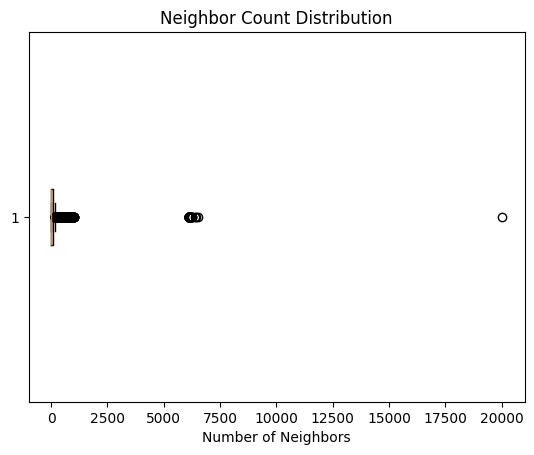

In [48]:
# box plot of neighbor counts
plt.boxplot(counts, vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

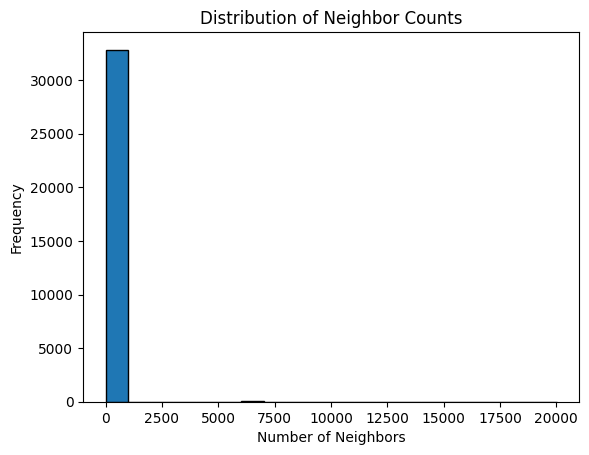

In [49]:
# histogram of neighbor counts
plt.hist(counts, bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [205]:
nodes = []
for microbe in set(sorted(md["microbe"])) | set(sorted(mmet["microbe"])):
    nodes.append([microbe, "microbe", "blue"])
for disease in set(sorted(md["disease"])) | set(sorted(hmdb_metd["disease"])):
    nodes.append([disease, "disease", "red"])
for metabolite in set(sorted(mmet["metabolite"])) | set(sorted(hmdb_metd["metabolite"])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("Full_MKG_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[microbe, disease, 1]
     for microbe, disease in md[["microbe", "disease"]].values]
)
edges.extend(
    [[microbe, metabolite, 1]
    for microbe, metabolite in mmet[["microbe", "metabolite"]].values]
)
edges.extend(
    [[metabolite, disease, 1]
    for metabolite, disease in hmdb_metd[["metabolite", "disease"]].values]
)

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("Full_MKG_edges_with_labels.csv", index=False)

### Summary of entire MKG datasets
- The MKG datasets consist of three relational datasets: Microbe-Disease (MD), Microbe-Metabolite (MMET), Metabolite_Disease (HMDB_METD).
- The MD dataset has 505,325 unique edges, the MMET dataset has 599,176 unique edges, and the HMDB_METD dataset has 27,546 unique edges. Total edges are 1,132,047.
- Total node count is 32,923 with 8202 unique microbes, 898 unique diseases, and 23823 unique metabolites.
- Common microbes in M-D: 3.81%; Common microbes in M-MET: 20.87%; Common diseases in M-D: 11.59%; Common diseases in HMDB_MET-D: 6.75%; Common metabolites in M-MET: 28.15%; Common metabolites in HMDB_MET-D: 2.14%.
- The relational datasets from MKG has 27 sub-graphs.
- Average neighbor count is ~69, median neighbor count is 1.

***

## Find the largest connected component in the MKG network

In [50]:
largest_cc = max(nx.connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc)

In [51]:
# find the maximum clique in largest subgraph
max_clique = max(nx.find_cliques(largest_subgraph), key=len)
print(f"Maximum clique: {max_clique}")

Maximum clique: ['PUBCHEM.COMPOUND:88412', 'NCBITaxon:1496', 'MONDO:0005575']


In [52]:
density = nx.density(largest_subgraph)
print(f"Density of largest subgraph: {density}")

Density of largest subgraph: 0.0020968065159428033


In [53]:
node_info = list(largest_subgraph.nodes(data=True))
edge_info = list(largest_subgraph.edges(data=True))

In [54]:
node_df = pd.DataFrame(node_info, columns=["Node", "Attributes"])
node_df.to_csv("MKG/largest_cc_nodes.csv", index=False)

In [55]:
print(node_df.head())

               Node           Attributes
0  NCBITaxon:165179  {'type': 'microbe'}
1     MONDO:0019100  {'type': 'disease'}
2    NCBITaxon:1686  {'type': 'microbe'}
3     MONDO:0005575  {'type': 'disease'}
4   NCBITaxon:68766  {'type': 'microbe'}


In [56]:
node_df['type'] = node_df['Attributes'].apply(lambda x: x.get('type'))
node_type_counts = node_df['type'].value_counts()
print(node_type_counts)

type
metabolite    23789
microbe        8191
disease         880
Name: count, dtype: int64


In [57]:
edge_df = pd.DataFrame(edge_info, columns=["Source", "Target", "Attributes"])
edge_df.to_csv("MKG/largest_cc_edges.csv", index=False)

In [58]:
edge_df['type'] = edge_df['Attributes'].apply(lambda x: x.get('type'))
edge_type_counts = edge_df['type'].value_counts()
print(edge_type_counts)

type
microbe_metabolite    599160
microbe_disease       505325
metabolite_disease     27525
Name: count, dtype: int64


I think I will start with the common microbes, diseases and metabolites as input data first...

***

## Find the common nodes and edges in the MKG network

In [207]:
disbiome_md = pd.read_csv("MKG/disbiome_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
gmmad2_mmet = pd.read_csv("MKG/gmmad2_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])
gmmad2_md = pd.read_csv("MKG/gmmad2_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
hmdb_metd = pd.read_csv("MKG/hmdb_met_disease.dat", sep="\t", encoding="utf-8", header=None, names=["metabolite", "disease"])
hmdb_mmet = pd.read_csv("MKG/hmdb_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])

In [208]:
md = pd.concat([disbiome_md, gmmad2_md])
mmet = pd.concat([gmmad2_mmet, hmdb_mmet])

In [178]:
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])

print(f"Number of common microbes: {len(common_microbes)}")
print(f"Number of common diseases: {len(common_diseases)}")
print(f"Number of common metabolites: {len(common_metabolites)}")

Number of common microbes: 273
Number of common diseases: 40
Number of common metabolites: 483


In [179]:
# find common microbes in md and mmet
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
filtered_md = md[md["microbe"].isin(common_microbes)]
filtered_mmet = mmet[mmet["microbe"].isin(common_microbes)]

missing_microbes = set(common_microbes) - set(filtered_md["microbe"])
print(f"Missing microbes: {missing_microbes}")
missing_microbes = set(common_microbes) - set(filtered_mmet["microbe"])
print(f"Missing microbes: {missing_microbes}")

# find common diseases in md and hmdb_metd
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
filtered_md = filtered_md[filtered_md["disease"].isin(common_diseases)]
filtered_hmdb_metd = hmdb_metd[hmdb_metd["disease"].isin(common_diseases)]

missing_diseases = set(common_diseases) - set(filtered_md["disease"])
print(f"Missing diseases: {missing_diseases}")
missing_diseases = set(common_diseases) - set(filtered_hmdb_metd["disease"])
print(f"Missing diseases: {missing_diseases}")

# find common metabolites in mmet and hmdb_metd
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])
filtered_mmet = filtered_mmet[filtered_mmet["metabolite"].isin(common_metabolites)]
filtered_hmdb_metd = filtered_hmdb_metd[filtered_hmdb_metd["metabolite"].isin(common_metabolites)]

missing_metabolites = set(common_metabolites) - set(filtered_mmet["metabolite"])
print(f"Missing metabolites: {missing_metabolites}")
print(f"count of missing metabolites: {len(missing_metabolites)}")
missing_metabolites = set(common_metabolites) - set(filtered_hmdb_metd["metabolite"])
print(f"Missing metabolites: {missing_metabolites}")
print(f"count of missing metabolites: {len(missing_metabolites)}")

# add weights if there are duplicate relationships
filtered_md["weight"] = filtered_md.groupby(["microbe", "disease"])["microbe"].transform("count")
filtered_mmet["weight"] = filtered_mmet.groupby(["microbe", "metabolite"])["microbe"].transform("count")
filtered_hmdb_metd["weight"] = filtered_hmdb_metd.groupby(["metabolite", "disease"])["metabolite"].transform("count")

# save as tab-separated .dat files
filtered_md.to_csv("MKG/common_microbe_disease.dat", sep="\t", index=False, header=False)
filtered_mmet.to_csv("MKG/common_microbe_metabolite.dat", sep="\t", index=False, header=False)
filtered_hmdb_metd.to_csv("MKG/common_metabolite_disease.dat", sep="\t", index=False, header=False)

Missing microbes: set()
Missing microbes: set()
Missing diseases: {'MONDO:0001711', 'MONDO:0002974', 'MONDO:0008315', 'MONDO:0016264', 'MONDO:0005649'}
Missing diseases: set()
Missing metabolites: {'CHEBI:15430', 'PUBCHEM.COMPOUND:3845', 'PUBCHEM.COMPOUND:12594', 'PUBCHEM.COMPOUND:6992567', 'PUBCHEM.COMPOUND:5810', 'PUBCHEM.COMPOUND:638072', 'PUBCHEM.COMPOUND:6213', 'PUBCHEM.COMPOUND:151138', 'PUBCHEM.COMPOUND:445408', 'PUBCHEM.COMPOUND:439373', 'PUBCHEM.COMPOUND:1738', 'PUBCHEM.COMPOUND:1826', 'PUBCHEM.COMPOUND:5280489', 'PUBCHEM.COMPOUND:65249', 'PUBCHEM.COMPOUND:5994', 'PUBCHEM.COMPOUND:3001028', 'PUBCHEM.COMPOUND:83697', 'PUBCHEM.COMPOUND:10742', 'PUBCHEM.COMPOUND:6329', 'PUBCHEM.COMPOUND:444718', 'PUBCHEM.COMPOUND:428', 'PUBCHEM.COMPOUND:8314', 'PUBCHEM.COMPOUND:328', 'PUBCHEM.COMPOUND:5997', 'PUBCHEM.COMPOUND:5280795', 'PUBCHEM.COMPOUND:11671', 'PUBCHEM.COMPOUND:168381', 'PUBCHEM.COMPOUND:5280445', 'PUBCHEM.COMPOUND:152323', 'PUBCHEM.COMPOUND:439194', 'PUBCHEM.COMPOUND:439260', '

In [180]:
print(f"Unique edges in filtered_md: {len(filtered_md[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in filtered_mmet: {len(filtered_mmet[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in filtered_hmdb_metd: {len(filtered_hmdb_metd[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in filtered_md: 4187
Unique edges in filtered_mmet: 11170
Unique edges in filtered_hmdb_metd: 903


In [181]:
filtered_common_microbes = set(filtered_md['microbe']).intersection(set(filtered_mmet['microbe']))
filtered_common_diseases = set(filtered_md['disease']).intersection(set(filtered_hmdb_metd['disease']))
filtered_common_metabolites = set(filtered_mmet['metabolite']).intersection(set(filtered_hmdb_metd['metabolite']))

print(f"Common Microbes in filtered M-D: {len(filtered_common_microbes) / len(filtered_md['microbe'].unique()) * 100:.2f}%")
print(f"Common Microbes in filtered M-MET: {len(filtered_common_microbes) / len(filtered_mmet['microbe'].unique()) * 100:.2f}%")
print(f"Common Diseases in filtered M-D: {len(filtered_common_diseases) / len(filtered_md['disease'].unique()) * 100:.2f}%")
print(f"Common Diseases in filtered HMDB_MET-D: {len(filtered_common_diseases) / len(filtered_hmdb_metd['disease'].unique()) * 100:.2f}%")
print(f"Common Metabolites in filtered M-MET: {len(filtered_common_metabolites) / len(filtered_mmet['metabolite'].unique()) * 100:.2f}%")
print(f"Common Metabolites in filtered HMDB_MET-D: {len(filtered_common_metabolites) / len(filtered_hmdb_metd['metabolite'].unique()) * 100:.2f}%")

Common Microbes in filtered M-D: 90.11%
Common Microbes in filtered M-MET: 96.34%
Common Diseases in filtered M-D: 85.71%
Common Diseases in filtered HMDB_MET-D: 88.24%
Common Metabolites in filtered M-MET: 78.45%
Common Metabolites in filtered HMDB_MET-D: 86.86%


In [182]:
# unique microbe count
unique_microbes = len(set(filtered_md['microbe']) | set(filtered_mmet['microbe']))

# unique disease count
unique_diseases = len(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease']))

# unique metabolite count
unique_metabolites = len(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite']))

# display the counts
print(f"Unique Microbes: {unique_microbes}")
print(f"Unique Diseases: {unique_diseases}")
print(f"Unique Metabolites: {unique_metabolites}")

Unique Microbes: 272
Unique Diseases: 39
Unique Metabolites: 462


In [183]:
G = nx.Graph()

for _, index in filtered_md.iterrows():
    G.add_edge(index["microbe"], index["disease"], weight=index["weight"], type="microbe_disease")
for _, index in filtered_mmet.iterrows():
    G.add_edge(index["microbe"], index["metabolite"], weight=index["weight"], type="microbe_metabolite")
for _, index in filtered_hmdb_metd.iterrows():
    G.add_edge(index["metabolite"], index["disease"], weight=index["weight"], type="metabolite_disease")

In [184]:
for node in G.nodes():
    if node in filtered_md['microbe'].values or node in filtered_mmet['microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in filtered_md['disease'].values or node in filtered_hmdb_metd['disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in filtered_mmet['metabolite'].values or node in filtered_hmdb_metd['metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [185]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 773
Total edges: 16260


In [186]:
degree_centrality = nx.degree_centrality(G)

In [187]:
density = nx.density(G)

In [188]:
components = nx.number_connected_components(G)

In [189]:
print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 5.45% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


In [190]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [191]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 773,
 'mean': np.float64(42.06985769728331),
 'std': np.float64(61.35830159184571),
 'min': np.int64(1),
 '25%': np.float64(8.0),
 '50% (median)': np.float64(18.0),
 '75%': np.float64(53.0),
 'max': np.int64(389)}

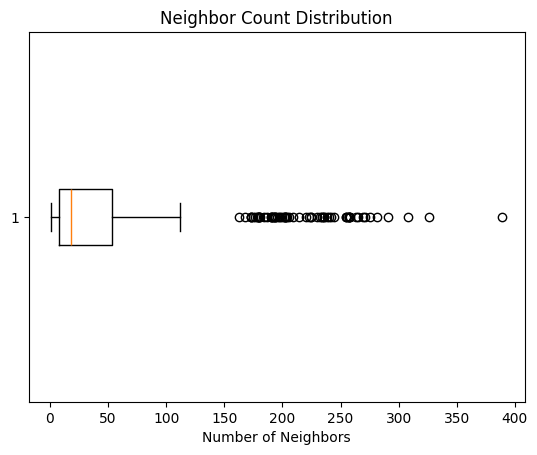

In [192]:
# box plot of neighbor counts
plt.boxplot(counts, vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

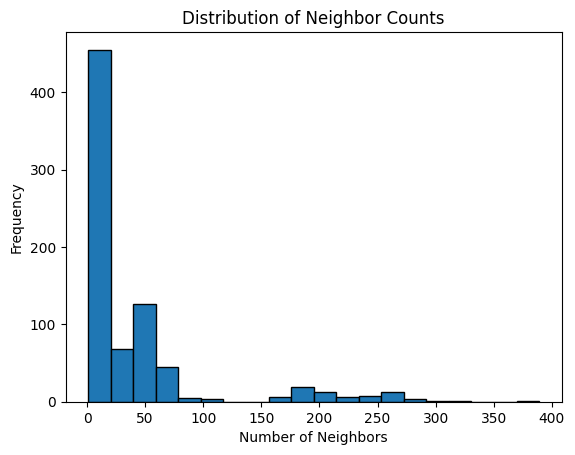

In [193]:
# histogram of neighbor counts
plt.hist(counts, bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [194]:
filtered_counts = {k: v for k, v in neighbor_counts.items() if v > 10}
print(f"Number of nodes with more than 10 neighbors: {len(filtered_counts)}")

Number of nodes with more than 10 neighbors: 556


### Summary of filtered MKG datasets with common nodes
- The filtered MKG datasets consist of three relational datasets: Microbe-Disease (MD), Microbe-Metabolite (MMET), and Metabolite-Disease (HMDB_METD).
- The MD dataset has 4,187 unique edges, the MMET dataset has 11,170 unique edges, and the HMDB_METD dataset has 903 unique edges. Total edges are 16,260.
- Total node count is 773 with 272 unique microbes, 39 unique diseases, and 462 unique metabolites.
- Common Microbes in filtered M-D: 90.11%; Common Microbes in filtered M-MET: 96.34%; Common Diseases in filtered M-D: 85.71%; Common Diseases in filtered HMDB_MET-D: 88.24%; Common Metabolites in filtered M-MET: 78.45%; Common Metabolites in filtered HMDB_MET-D: 86.86%.
- The relational datasets from filtered MKG has 1 connected large component.
- Average neighbor count is 42, median neighbor count is 18.

***

In [76]:
# assign indices to each unique node type and export data
microbes = set(filtered_md['microbe']) | set(filtered_mmet['microbe'])
diseases = set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])
metabolites = set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])

# create index mappings
microbe_index = {microbe: idx for idx, microbe in enumerate(sorted(microbes))}
disease_index = {disease: idx for idx, disease in enumerate(sorted(diseases))}
metabolite_index = {metabolite: idx for idx, metabolite in enumerate(sorted(metabolites))}

# replace nodes in filtered datasets with their indices
filtered_md_indexed = filtered_md.copy()
filtered_md_indexed['microbe'] = filtered_md_indexed['microbe'].map(microbe_index)
filtered_md_indexed['disease'] = filtered_md_indexed['disease'].map(disease_index)

filtered_mmet_indexed = filtered_mmet.copy()
filtered_mmet_indexed['microbe'] = filtered_mmet_indexed['microbe'].map(microbe_index)
filtered_mmet_indexed['metabolite'] = filtered_mmet_indexed['metabolite'].map(metabolite_index)

filtered_hmdb_metd_indexed = filtered_hmdb_metd.copy()
filtered_hmdb_metd_indexed['metabolite'] = filtered_hmdb_metd_indexed['metabolite'].map(metabolite_index)
filtered_hmdb_metd_indexed['disease'] = filtered_hmdb_metd_indexed['disease'].map(disease_index)

In [77]:
print(f"Unique edges in filtered_md_indexed: {len(filtered_md_indexed[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in filtered_mmet_indexed: {len(filtered_mmet_indexed[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in filtered_hmdb_metd_indexed: {len(filtered_hmdb_metd_indexed[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in filtered_md_indexed: 4187
Unique edges in filtered_mmet_indexed: 11170
Unique edges in filtered_hmdb_metd_indexed: 903


In [78]:
# save indexed datasets for common nodes
filtered_md_indexed.to_csv("MKG/common_microbe_disease_idx.dat", sep="\t", index=False, header=False)
filtered_mmet_indexed.to_csv("MKG/common_microbe_metabolite_idx.dat", sep="\t", index=False, header=False)
filtered_hmdb_metd_indexed.to_csv("MKG/common_metabolite_disease_idx.dat", sep="\t", index=False, header=False)

# export unique nodes with their indices
pd.DataFrame(microbe_index.items(), columns=["microbe", "index"]).to_csv("MKG/unique_microbes_idx.dat", sep="\t", index=False, header=False)
pd.DataFrame(disease_index.items(), columns=["disease", "index"]).to_csv("MKG/unique_diseases_idx.dat", sep="\t", index=False, header=False)
pd.DataFrame(metabolite_index.items(), columns=["metabolite", "index"]).to_csv("MKG/unique_metabolites_idx.dat", sep="\t", index=False, header=False)

In [79]:
# create files for cosmograph visualization
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])

# add metabolites with a color
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors.csv", index=False)

# edge file
edges = []

# add microbe-disease edges
edges.extend(filtered_md[["microbe", "disease", "weight"]].values.tolist())

# add microbe-metabolite edges
edges.extend(filtered_mmet[["microbe", "metabolite", "weight"]].values.tolist())

# add metabolite-disease edges
edges.extend(filtered_hmdb_metd[["metabolite", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels.csv", index=False)

773
16260


In [80]:
# create files for cosmograph visualization (remove metabolites)
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])


nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_met.csv", index=False)

# edge file
edges = []

# add microbe-disease edges
edges.extend(filtered_md[["microbe", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_met.csv", index=False)

311
4187


In [81]:
# create files for cosmograph visualization (remove microbes)
# node file
nodes = []

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])

# add metabolites with a color
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_micro.csv", index=False)

# edge file
edges = []

# add metabolite-disease edges
edges.extend(filtered_hmdb_metd[["metabolite", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_micro.csv", index=False)

501
903


In [210]:
# create files for cosmograph visualization (remove diseases)
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_dis.csv", index=False)

# edge file
edges = []

# add microbe-metabolite edges
edges.extend(filtered_mmet[["microbe", "metabolite", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_dis.csv", index=False)